In [1]:
from __future__ import print_function
import argparse
import os
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


import numpy as np
import pandas as pd
from PIL import Image
import time
import glob
import imageio
import cv2
import pathlib
import zipfile
import sys
import pandas as pd

import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from IPython import display
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install graphviz
!pip install torchsummary
! pip install torchview
from torchsummary import summary
import torchvision
from torchview import draw_graph

In [4]:
!unzip "/content/drive/MyDrive/WGAN New Dataset/MedGAN_data.zip" -d /content/extracted_files

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/extracted_files/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/extr

In [5]:
dataroot = "/content/extracted_files"
workers = 2
batch_size = 128
image_size = 256
nc = 1
nz = 256
ngf = 64
ndf = 64
ngpu = 1

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [7]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(),
                               transforms.Resize((image_size, image_size)),
#                                transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
!pip install torchsummary


In [9]:
class Generator (nn.Module):
    """ a model generates fake images """
    def __init__ (self, z_dim=nz, img_channels=1, features_g=32):
        super (Generator, self).__init__ ()

        # Input: N x z_dim x 1 x 1
        self.gen = nn.Sequential (
            self._block(z_dim, features_g * 32, 4, 2, 0),      # 4x4
            self._block(features_g * 32, features_g * 16, 4, 2, 1), # 8x8
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 16x16
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # 32x32
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # 64x64
            self._block(features_g * 2, features_g, 4, 2, 1),       # 128x128
            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1),  # 256x256
            nn.Tanh()
        )



    def _block (self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential (
            nn.ConvTranspose2d (in_channels, out_channels, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d (out_channels),
            nn.ReLU ()
        )

    def forward (self, x):
        return self.gen (x)
summary(Generator().to(device), (nz,1,1))
print(Generator(z_dim = nz, img_channels = 1, features_g = 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [10]:
transforms.Resize((image_size, image_size))

Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)

In [11]:

import torch.nn.functional as F

class Critic(torch.nn.Module):

    def __init__(self, num_classes=2):
        super(Critic, self).__init__()

        #########################
        ### 1st residual block
        #########################
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_1_bn = torch.nn.InstanceNorm2d(4)

        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_2_bn = torch.nn.InstanceNorm2d(8)

        self.conv_shortcut_1 = torch.nn.Conv2d(in_channels=1,
                                               out_channels=8,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_1_bn = torch.nn.InstanceNorm2d(8)

        #########################
        ### 2nd residual block
        #########################
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_3_bn = torch.nn.InstanceNorm2d(16)

        # 7x7x16 => 7x7x32
        self.conv_4 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_4_bn = torch.nn.InstanceNorm2d(32)

        # 14x14x8 => 7x7x32
        self.conv_shortcut_2 = torch.nn.Conv2d(in_channels=8,
                                               out_channels=32,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_2_bn = torch.nn.InstanceNorm2d(32)

        #########################
        ### 3nd residual block
        #########################
        self.conv_5 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1)
        self.conv_5_bn = torch.nn.InstanceNorm2d(64)

        self.conv_6 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=128,
                                      kernel_size=(1, 1),
                                      stride=(1, 1),
                                      padding=0)
        self.conv_6_bn = torch.nn.InstanceNorm2d(128)

        self.conv_shortcut_3 = torch.nn.Conv2d(in_channels=32,
                                               out_channels=128,
                                               kernel_size=(1, 1),
                                               stride=(2, 2),
                                               padding=0)
        self.conv_shortcut_3_bn = torch.nn.InstanceNorm2d(128)


        #########################
        ### Fully connected
        #########################
        self.flat=nn.Flatten()

        self.linear_1 = torch.nn.Linear(32*32*128, 1)
        self.final = nn.Identity()  # or just remove the final activation layer




        self.relu = nn.LeakyReLU(0.2, inplace=True)
        # self.relu = nn.ReLU()

    def forward(self, x):

        #########################
        ### 1st residual block
        #########################
        shortcut = x

        out = self.conv_1(x) # 28x28x1 => 14x14x4
        out = self.conv_1_bn(out)
        out = self.relu(out)

        out = self.conv_2(out) # 14x14x4 => 714x14x8
        out = self.conv_2_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_1(shortcut)
        shortcut = self.conv_shortcut_1_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### 2nd residual block
        #########################

        shortcut = out

        out = self.conv_3(out)
        out = self.conv_3_bn(out)
        out = F.relu(out)

        out = self.conv_4(out)
        out = self.conv_4_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_2(shortcut)
        shortcut = self.conv_shortcut_2_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### 3rd residual block
        #########################

        shortcut = out

        out = self.conv_5(out)
        out = self.conv_5_bn(out)
        out = self.relu(out)

        out = self.conv_6(out)
        out = self.conv_6_bn(out)

        # match up dimensions using a linear function (no relu)
        shortcut = self.conv_shortcut_3(shortcut)
        shortcut = self.conv_shortcut_3_bn(shortcut)

        out += shortcut
        out = self.relu(out)

        #########################
        ### Fully connected
        #########################
        out=self.flat(out)
        out = self.linear_1(out)
        out=self.final(out)

        return out



model = Critic()
model = model.to(device)

In [12]:
def get_noise(n_samples, nz, device='cpu'):
    return torch.randn(n_samples,nz,1,1,device=device)

In [13]:
fixed_noise = get_noise(batch_size, nz, device=device)

In [14]:
fixed_noise.shape

torch.Size([128, 256, 1, 1])

Time is 0.8651986122131348 sec
Shape of loading one batch: torch.Size([128, 1, 256, 256])
Total no. of batches present in trainloader: 55


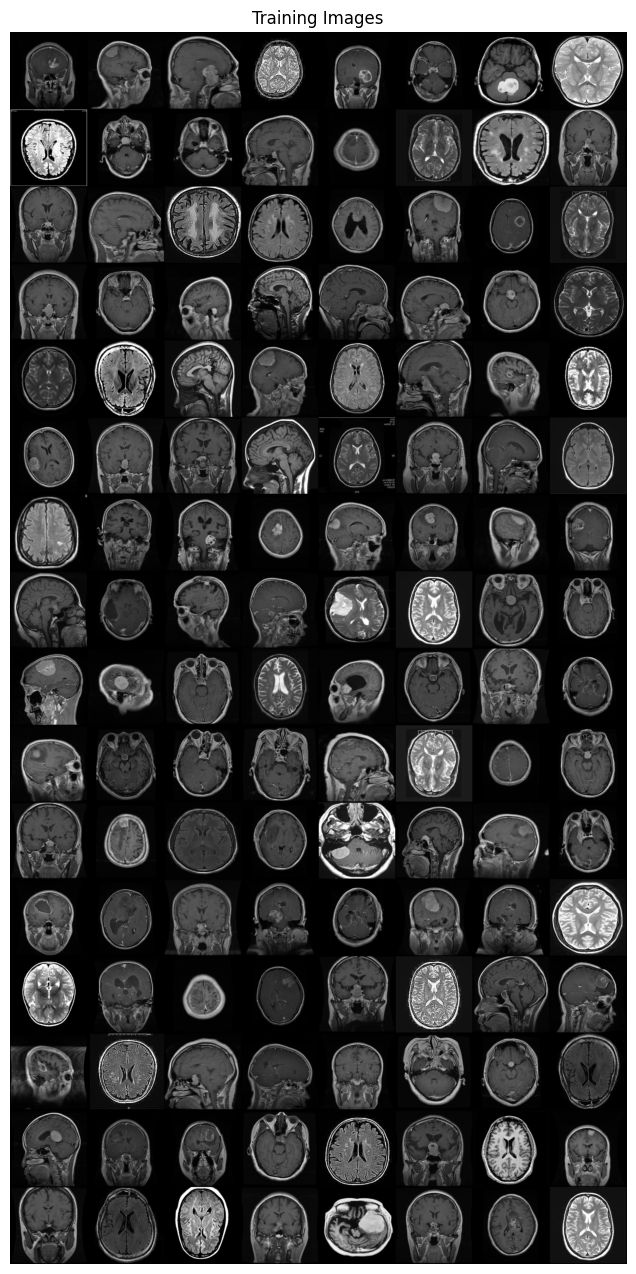

In [15]:
start = time.time()
dataiter = iter(dataloader)
images,labels = dataiter.__next__()
print ('Time is {} sec'.format(time.time()-start))

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [16]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [17]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [18]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [19]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)

    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,

    )[0]
    return gradient

In [20]:
lr_g = 0.0002
lr_c = 0.0002
beta_1 = 0.0
beta_2 = 0.99



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


criterion = nn.BCELoss()


gen = Generator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    gen = nn.DataParallel(gen, list(range(ngpu)))

crit  = Critic().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    crit = nn.DataParallel(crit, list(range(ngpu)))


gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_g, betas=(beta_1, beta_2))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr_c, betas=(beta_1, beta_2))





gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [21]:
def show_tensor_images(image_tensor, num_images=25, size=(nc, image_size, image_size), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5,normalize=True)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show_fig:
        plt.savefig('gez_images_256_2\image_at_epoch_{:04d}.png'.format(epoch))

    # plt.show()

# Hamza Edit


In [36]:
# Update the training parameters
start_epoch = 60  # The last completed epoch
additional_epochs = 300  # Total epochs you want to reach minus the start_epoch (500 - 207)
n_epochs = start_epoch + additional_epochs


In [23]:
"""
# Paths to the latest files
gen_path = "/content/drive/MyDrive/WGAN New Dataset/generator_latest.pt"
crit_path = "/content/drive/MyDrive/WGAN New Dataset/critic_latest.pt"
gen_opt_path = "/content/drive/MyDrive/WGAN New Dataset/gen_opt_latest.pt"
crit_opt_path = "/content/drive/MyDrive/WGAN New Dataset/crit_opt_latest.pt"

# Load the model and optimizer states
gen.load_state_dict(torch.load(gen_path))
crit.load_state_dict(torch.load(crit_path))
gen_opt.load_state_dict(torch.load(gen_opt_path))
crit_opt.load_state_dict(torch.load(crit_opt_path))
"""

'\n# Paths to the latest files\ngen_path = "/content/drive/MyDrive/WGAN New Dataset/generator_latest.pt"\ncrit_path = "/content/drive/MyDrive/WGAN New Dataset/critic_latest.pt"\ngen_opt_path = "/content/drive/MyDrive/WGAN New Dataset/gen_opt_latest.pt"\ncrit_opt_path = "/content/drive/MyDrive/WGAN New Dataset/crit_opt_latest.pt"\n\n# Load the model and optimizer states\ngen.load_state_dict(torch.load(gen_path))\ncrit.load_state_dict(torch.load(crit_path))\ngen_opt.load_state_dict(torch.load(gen_opt_path))\ncrit_opt.load_state_dict(torch.load(crit_opt_path))\n'

In [23]:
n_epochs = 100
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

img_list = []

iters = 0


In [24]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3

# This is the snippet you provided for calculation functions
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    if cuda:
        images = images.cuda()

    # Get the output from the model
    pred = model(images)

    # Inception v3 returns a tuple, we want the features (first element)
    # BUT only if it IS a tuple
    if isinstance(pred, tuple):
        pred = pred[0]

    # If the output is not already spatially flattened, apply average pooling
    if len(pred.size()) > 2:  # Check if pred has more than 2 dimensions
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    # Reshape to (batch_size, features)
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid
# Function to calculate Inception Score
def calculate_inception_score(images, inception_model, batch_size=128, splits=10, cuda=False):
    inception_model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            preds.append(F.softmax(inception_model(batch), dim=1).cpu().numpy())  # Get softmax probabilities

    preds = np.concatenate(preds, axis=0)
    split_scores = []

    for k in range(splits):
        part = preds[k * (preds.shape[0] // splits):(k + 1) * (preds.shape[0] // splits), :]
        p_y = np.mean(part, axis=0)
        scores = part * (np.log(part + 1e-6) - np.log(p_y + 1e-6))
        split_scores.append(np.exp(np.mean(np.sum(scores, axis=1))))

    return np.mean(split_scores), np.std(split_scores)

In [25]:
from torchvision.models import inception_v3
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model for FID (fc=Identity to get 2048D features)
inception_model_fid = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model_fid.fc = nn.Identity()
inception_model_fid.eval()

# Model for IS (original Inception with classification head)
inception_model_is = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model_is.eval()

# Extract features from the avgpool layer
def get_inception_features(images):
    with torch.no_grad():
        features = inception_model_fid(images) # Now returns [N, 2048] directly
        # No need for extra checks or pooling if fc is Identity
        return features


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 145MB/s]


In [27]:
# Extract features batch by batch
all_activations = []

for real_batch, _ in dataloader:
    real_batch = real_batch.to(device)

    # If grayscale, replicate to 3 channels
    if real_batch.shape[1] == 1:
        real_batch = real_batch.repeat(1, 3, 1, 1)

    # Scale from [-1,1] to [0,1]
    real_batch = (real_batch + 1) / 2.0

    # Resize to 299x299 for Inception
    real_batch = F.interpolate(real_batch, size=(299, 299), mode='bilinear', align_corners=False)

    # Get Inception features
    features = get_inception_features(real_batch)
    all_activations.append(features.cpu().numpy())

# Concatenate all activations
all_activations = np.concatenate(all_activations, axis=0)

# Calculate mean and covariance
mu_real = np.mean(all_activations, axis=0)
sigma_real = np.cov(all_activations, rowvar=False)

# Save results
np.save("/content/drive/MyDrive/WGAN New Dataset/mu_real.npy", mu_real)
np.save("/content/drive/MyDrive/WGAN New Dataset/sigma_real.npy", sigma_real)


In [26]:
!pip install scikit-image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


In [27]:
checkpoint = torch.load("/content/drive/MyDrive/WGAN New Dataset/checkpoint_epoch_X.pt", map_location=device)
gen.load_state_dict(checkpoint['gen_state_dict'])
crit.load_state_dict(checkpoint['crit_state_dict'])
gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
crit_opt.load_state_dict(checkpoint['crit_opt_state_dict'])
start_epoch = checkpoint['epoch'] + 1
generator_losses = checkpoint['generator_losses']
critic_losses = checkpoint['critic_losses']
fixed_noise = checkpoint['fixed_noise']


<ipython-input-27-2933001b1048>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/WGAN New Dataset/checkpoint_epoch_X.pt", map

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Step 50: Generator loss: 20.749478969573975, critic loss: -7.669455804347991

Epoch: 60/360 Total Steps:55	Total_Time : 719.136278	Loss_C : -8.684386	Loss_G : 21.542227	Loss_C_Mean : -7.698722	Loss_G_Mean : 21.086147	

Step 50: Generator loss: 19.933125824928283, critic loss: -7.7464043149948125

Epoch: 61/360 Total Steps:110	Total_Time : 1061.540424	Loss_C : -6.535279	Loss_G : 8.314964	Loss_C_Mean : -7.733507	Loss_G_Mean : 19.318793	

Step 50: Generator loss: 22.986902241706847, critic loss: -7.672229826927184

Epoch: 62/360 Total Steps:165	Total_Time : 1403.953629	Loss_C : -7.767420	Loss_G : 15.600302	Loss_C_Mean : -7.683585	Loss_G_Mean : 22.785927	

Step 50: Generator loss: 21.822878828048704, critic loss: -7.659032754898073

Epoch: 63/360 Total Steps:220	Total_Time : 1747.127689	Loss_C : -7.865055	Loss_G : 16.629606	Loss_C_Mean : -7.718430	Loss_G_Mean : 21.976249	

Step 50: Generator loss: 21.014982442855835, critic loss: -7.678175506114961

Epoch: 64/360 Total Steps:275	Total_Tim

KeyboardInterrupt: 

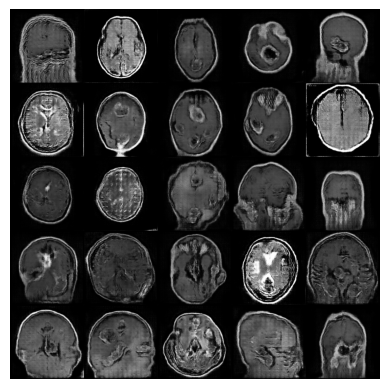

In [37]:
for epoch in range(start_epoch, n_epochs):
    cur_step = 0
    start = time.time()
    i = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            # Update critic
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, nz, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            crit_loss.backward(retain_graph=True)
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        # Update generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, nz, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)

        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        gen_opt.step()
        generator_losses += [gen_loss.item()]

        cur_step += 1
        total_steps += 1

        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(dataloader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"
        print(print_val, end='\r', flush=True)

        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        i += 1

        if cur_step % display_step == 0 and cur_step > 0:
            print()
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step

    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)

    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)

    #showing the Generated image
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    show_tensor_images(fake, show_fig=True, epoch=epoch)


    # Optionally save checkpoint every 10 epochs
    if epoch % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'crit_state_dict': crit.state_dict(),
            'gen_opt_state_dict': gen_opt.state_dict(),
            'crit_opt_state_dict': crit_opt.state_dict(),
            'fixed_noise': fixed_noise,
            'generator_losses': generator_losses,
            'critic_losses': critic_losses
        }
        torch.save(checkpoint, f"/content/drive/MyDrive/WGAN New Dataset/checkpoint_epoch_X.pt")

# After the loop ends, save the final checkpoint
checkpoint = {
    'epoch': epoch,
    'gen_state_dict': gen.state_dict(),
    'crit_state_dict': crit.state_dict(),
    'gen_opt_state_dict': gen_opt.state_dict(),
    'crit_opt_state_dict': crit_opt.state_dict(),
    'fixed_noise': fixed_noise,
    'generator_losses': generator_losses,
    'critic_losses': critic_losses
}
torch.save(checkpoint, "/content/drive/MyDrive/WGAN New Dataset/final_checkpoint.pt")


In [38]:
# In case the final loop didn't finish
checkpoint = {
  #  'epoch': epoch,
    'gen_state_dict': gen.state_dict(),
    'crit_state_dict': crit.state_dict(),
    'gen_opt_state_dict': gen_opt.state_dict(),
    'crit_opt_state_dict': crit_opt.state_dict(),
    'fixed_noise': fixed_noise,
    'generator_losses': generator_losses,
    'critic_losses': critic_losses
}
torch.save(checkpoint, "/content/drive/MyDrive/WGAN New Dataset/final_checkpoint.pt")

In [39]:
# Load the final trained model
checkpoint = torch.load("/content/drive/MyDrive/WGAN New Dataset/final_checkpoint.pt", map_location=device)
gen.load_state_dict(checkpoint['gen_state_dict'])
gen.eval()

# Load real stats for FID
mu_real = np.load("/content/drive/MyDrive/WGAN New Dataset/mu_real.npy")
sigma_real = np.load("/content/drive/MyDrive/WGAN New Dataset/sigma_real.npy")

num_images_for_metrics = 1000
batch_for_metrics = 50
all_fake_activations = []
all_fake_images = []

with torch.no_grad():
    for _ in range(num_images_for_metrics // batch_for_metrics):
        noise = get_noise(batch_for_metrics, nz, device=device)
        fakes = gen(noise)

        # If grayscale, replicate channels
        if fakes.shape[1] == 1:
            fakes = fakes.repeat(1, 3, 1, 1)

        # Scale to [0, 1] and resize
        fakes = (fakes + 1) / 2.0
        fakes = F.interpolate(fakes, size=(299, 299), mode='bilinear', align_corners=False)

        # Extract activations for FID
        features = get_inception_features(fakes)
        all_fake_activations.append(features.cpu().numpy())

        # Store images for IS
        all_fake_images.append(fakes.cpu())

gen.train()

# Combine activations and calculate FID
all_fake_activations = np.concatenate(all_fake_activations, axis=0)
mu_fake = np.mean(all_fake_activations, axis=0)
sigma_fake = np.cov(all_fake_activations, rowvar=False)
fid = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID: {fid:.4f}")

# Combine images and calculate IS
all_fake_images = torch.cat(all_fake_images, dim=0)  # Combine all fake images
all_fake_images = all_fake_images.to(device)
is_mean, is_std = calculate_inception_score(all_fake_images, inception_model_is, batch_size=batch_for_metrics, cuda=device.type == 'cuda')
print(f"IS: {is_mean:.4f} ± {is_std:.4f}")

# Compute SSIM/PSNR on a sample batch
# Take one batch of real and a corresponding set of fake images:
real_iter = iter(dataloader)
real_batch, _ = next(real_iter)
real_batch = real_batch.to(device)
fake_batch = gen(fixed_noise[:len(real_batch)])
real_np = real_batch.cpu().permute(0,2,3,1).numpy()
fake_np = fake_batch.cpu().detach().permute(0,2,3,1).numpy()

ssim_scores = []
psnr_scores = []
for i in range(len(real_np)):
    real_img_01 = (real_np[i] + 1) / 2
    fake_img_01 = (fake_np[i] + 1) / 2

    ssim_val = ssim(real_img_01[...,0], fake_img_01[...,0], data_range=1.0)
    psnr_val = psnr(real_img_01, fake_img_01, data_range=1.0)
    ssim_scores.append(ssim_val)
    psnr_scores.append(psnr_val)
avg_ssim = sum(ssim_scores)/len(ssim_scores)
avg_psnr = sum(psnr_scores)/len(psnr_scores)
print(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}")


<ipython-input-39-16d6f1dce1d3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/WGAN New Dataset/final_checkpoint.pt", map_l

FID: 116.0234
IS: 2.3033 ± 0.0971
SSIM: 0.2540, PSNR: 13.4594


In [40]:
print(f"mu_real shape: {mu_real.shape}, sigma_real shape: {sigma_real.shape}")
print(f"mu_fake shape: {mu_fake.shape}, sigma_fake shape: {sigma_fake.shape}")
#let GPT o1 check you metric
#check your full code
#check that every metric is correct
#make metric only in the end

mu_real shape: (2048,), sigma_real shape: (2048, 2048)
mu_fake shape: (2048,), sigma_fake shape: (2048, 2048)


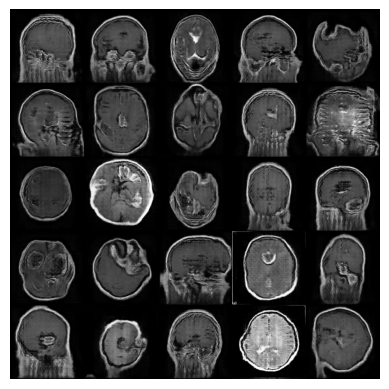

In [41]:
image_path = "/content/drive/MyDrive/gan_outputs/generated_images/epoch_{}.png".format(epoch)
# Ensure the directory exists
os.makedirs(os.path.dirname(image_path), exist_ok=True)
# Save the image
show_tensor_images(fake, show_fig=True, epoch=epoch)  # your image saving function
plt.savefig(image_path)


# End of it ---------------

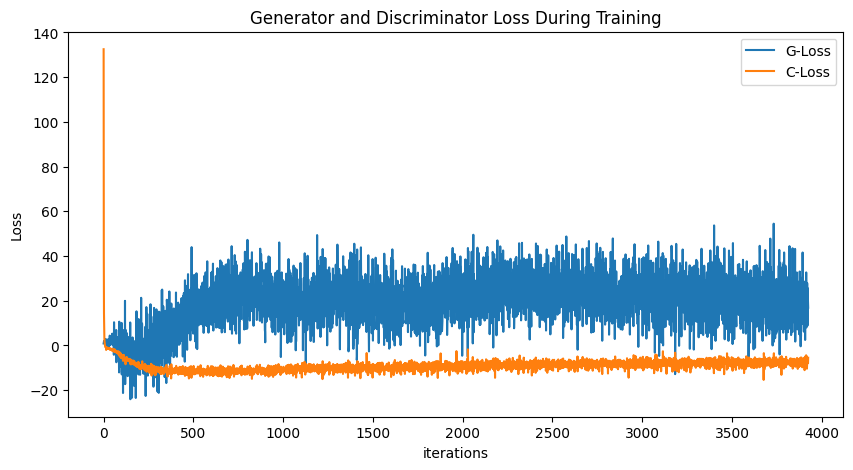

In [42]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

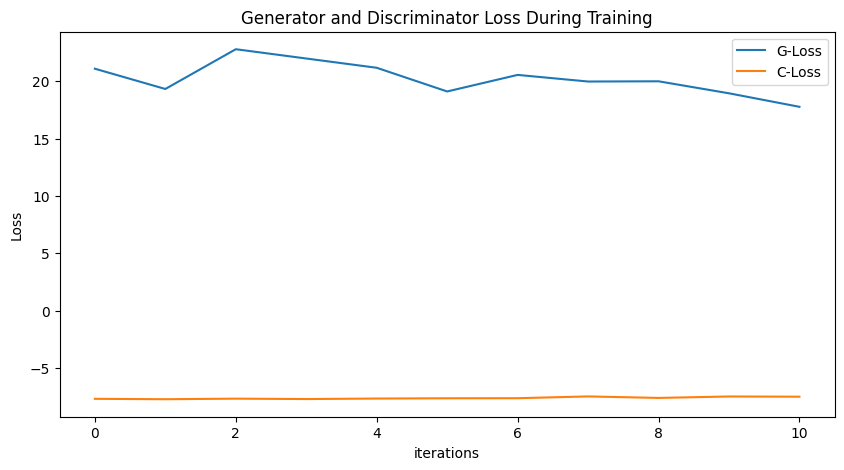

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(C_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

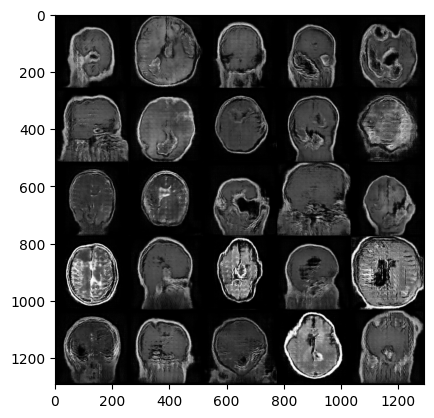

In [44]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, nz, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,nc,image_size,image_size))

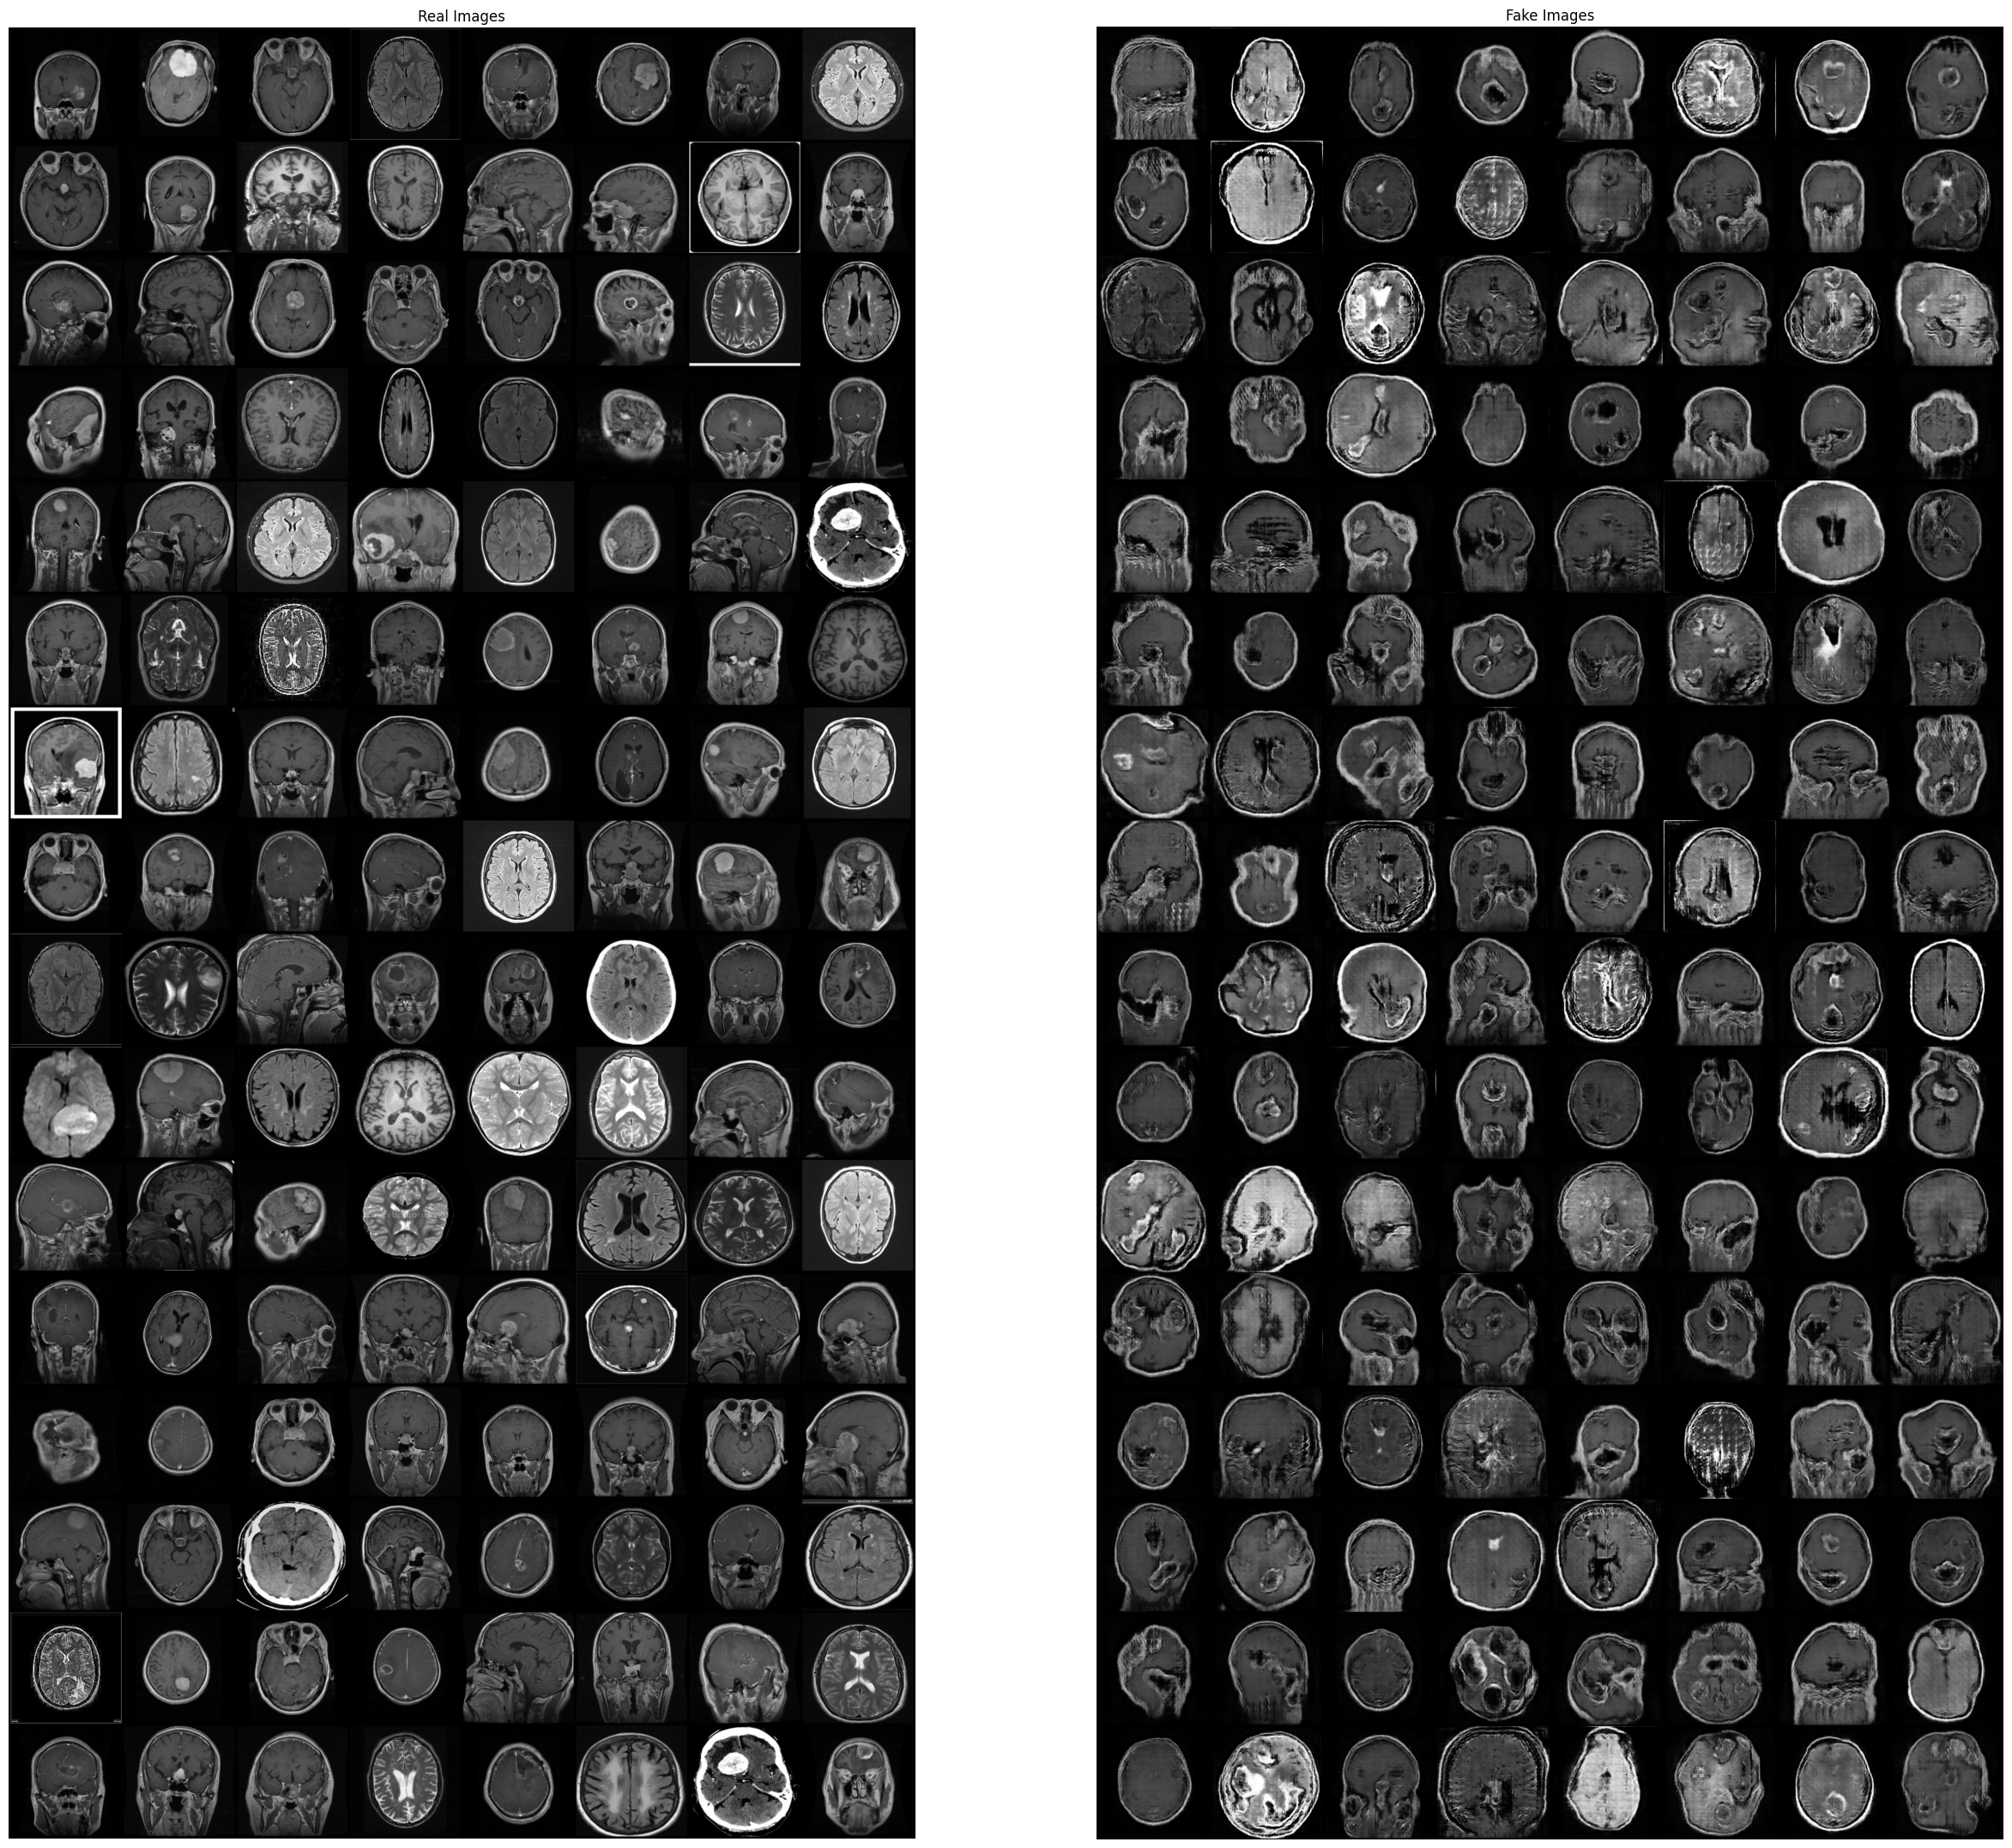

In [45]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png',dpi=300)
plt.show()

<ipython-input-46-29cb127c7861>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-46-29cb127c7861>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 5.6 MB/s eta 0:00:00



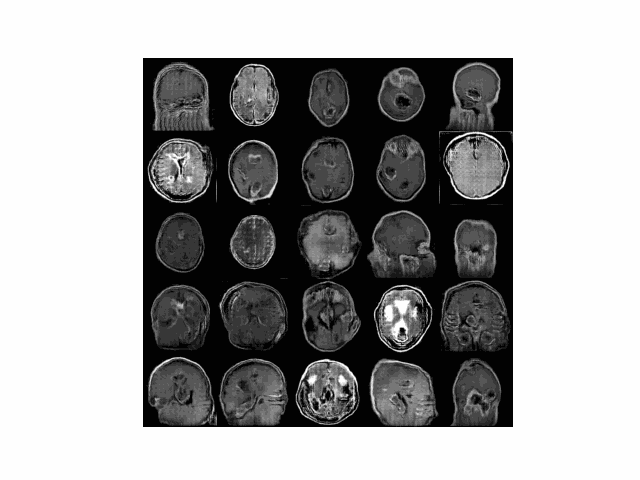

In [46]:
anim_file = 'WGAN-GAN_128_Res_ins.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('gez_images_256_2\image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

!pip install tensorflow-docs
# !pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [47]:
gen.load_state_dict(checkpoint['gen_state_dict'])  # Load the generator weights
gen.eval()  # Set the model to evaluation mode


Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

In [48]:
import h5py
import pickle

# Save model weights as .h5
h5_path = "generator.h5"
with h5py.File(h5_path, "w") as h5_file:
    for param_name, param_value in gen.state_dict().items():
        h5_file.create_dataset(param_name, data=param_value.cpu().numpy())

# Save model weights as .pkl
pkl_path = "generator.pkl"
with open(pkl_path, "wb") as pkl_file:
    pickle.dump(gen.state_dict(), pkl_file)

print(f"Model saved as:\n  - {h5_path}\n  - {pkl_path}")


Model saved as:
  - generator.h5
  - generator.pkl


In [49]:
import h5py
import pickle
import os

# Set paths to save in Google Drive
drive_path = "/content/drive/MyDrive/WGAN New Dataset"
os.makedirs(drive_path, exist_ok=True)  # Create the directory if it doesn't exist

h5_path = os.path.join(drive_path, "generator.h5")
pkl_path = os.path.join(drive_path, "generator.pkl")

# Save model weights as .h5
with h5py.File(h5_path, "w") as h5_file:
    for param_name, param_value in gen.state_dict().items():
        h5_file.create_dataset(param_name, data=param_value.cpu().numpy())

# Save model weights as .pkl
with open(pkl_path, "wb") as pkl_file:
    pickle.dump(gen.state_dict(), pkl_file)

print(f"Model saved in Google Drive as:\n  - {h5_path}\n  - {pkl_path}")


Model saved in Google Drive as:
  - /content/drive/MyDrive/WGAN New Dataset/generator.h5
  - /content/drive/MyDrive/WGAN New Dataset/generator.pkl
